<h1>Analysis of Tumor Exome Mutations</h1>

<!--[cancer_cells](https://swami.wustl.edu/wp-content/uploads/2015/07/cancers-cells-1038x576.jpg)-->
<img src="https://swami.wustl.edu/wp-content/uploads/2015/07/cancers-cells-1038x576.jpg" alt="cancer cells" width="600px">

<h2>Author: Yogindra Raghav</h2>
<h2>April 2019</h2>

In [1]:
import pandas
import itertools 
import collections
import matplotlib.pyplot as plt

<h3>Load All DataFrames into Dict</h3>

In [2]:
# dict for all MAF data 
all_mafs = {}

# for all 50 MAF files 
for i in range(0,50): 
    # load all MAF data into dict using patient number as key 
    all_mafs["Patient-"+str(i)] = pandas.read_csv("mafs/Patient-"+str(i)+".somatic.snvs.maf", sep="\t")
    

<h3>Subset for: NOT Variant Classification "Silent"</h3>

In [3]:
# dict for dataframes subsetted for non-silent variants 
not_silent = {} 

# for all MAFs
for maf in all_mafs: 
    # subset for variants that are not "silent" variants 
    not_silent[maf] = all_mafs[maf].loc[all_mafs[maf]["Variant_Classification"]!="Silent"]


<h3>Create Histogram of 10 Most Common Mutations</h3>

**Populate Dict to Build Histogram**

In [4]:
# dict for plotting histogram 
histogram_plot_dict = {} 

# for each dataframe 
for dataframe in not_silent: 
    # get list of hugo symbols from dataframe
    hugo_genes = not_silent[dataframe]["Hugo_Symbol"].tolist()
    
    # update histogram dict for future plotting 
    for gene in hugo_genes:
        if gene in histogram_plot_dict: 
            histogram_plot_dict[gene] +=1
        else: 
            histogram_plot_dict[gene] = 1

**Pull 10 Highest Counts' Genes**

In [19]:
# sort dict by values (highest to lowest) 
histogram_plot_dict={k: v for k, v in sorted(histogram_plot_dict.items(), key=lambda item: item[1], reverse=True)}

# pull first 10 times and coerce to dict for future plotting 
histogram_plot_dict = dict(itertools.islice(histogram_plot_dict.items(), 0,10))

# print dict clean 
for gene in histogram_plot_dict: 
    print(gene+"\t"+str(histogram_plot_dict[gene]))

TTN	41
TP53	30
ERBB4	27
MUC16	22
SPEN	22
KMT2C	20
KMT2D	17
ERBB3	16
FRG1B	14
ZNF91	13



**Create Figure**

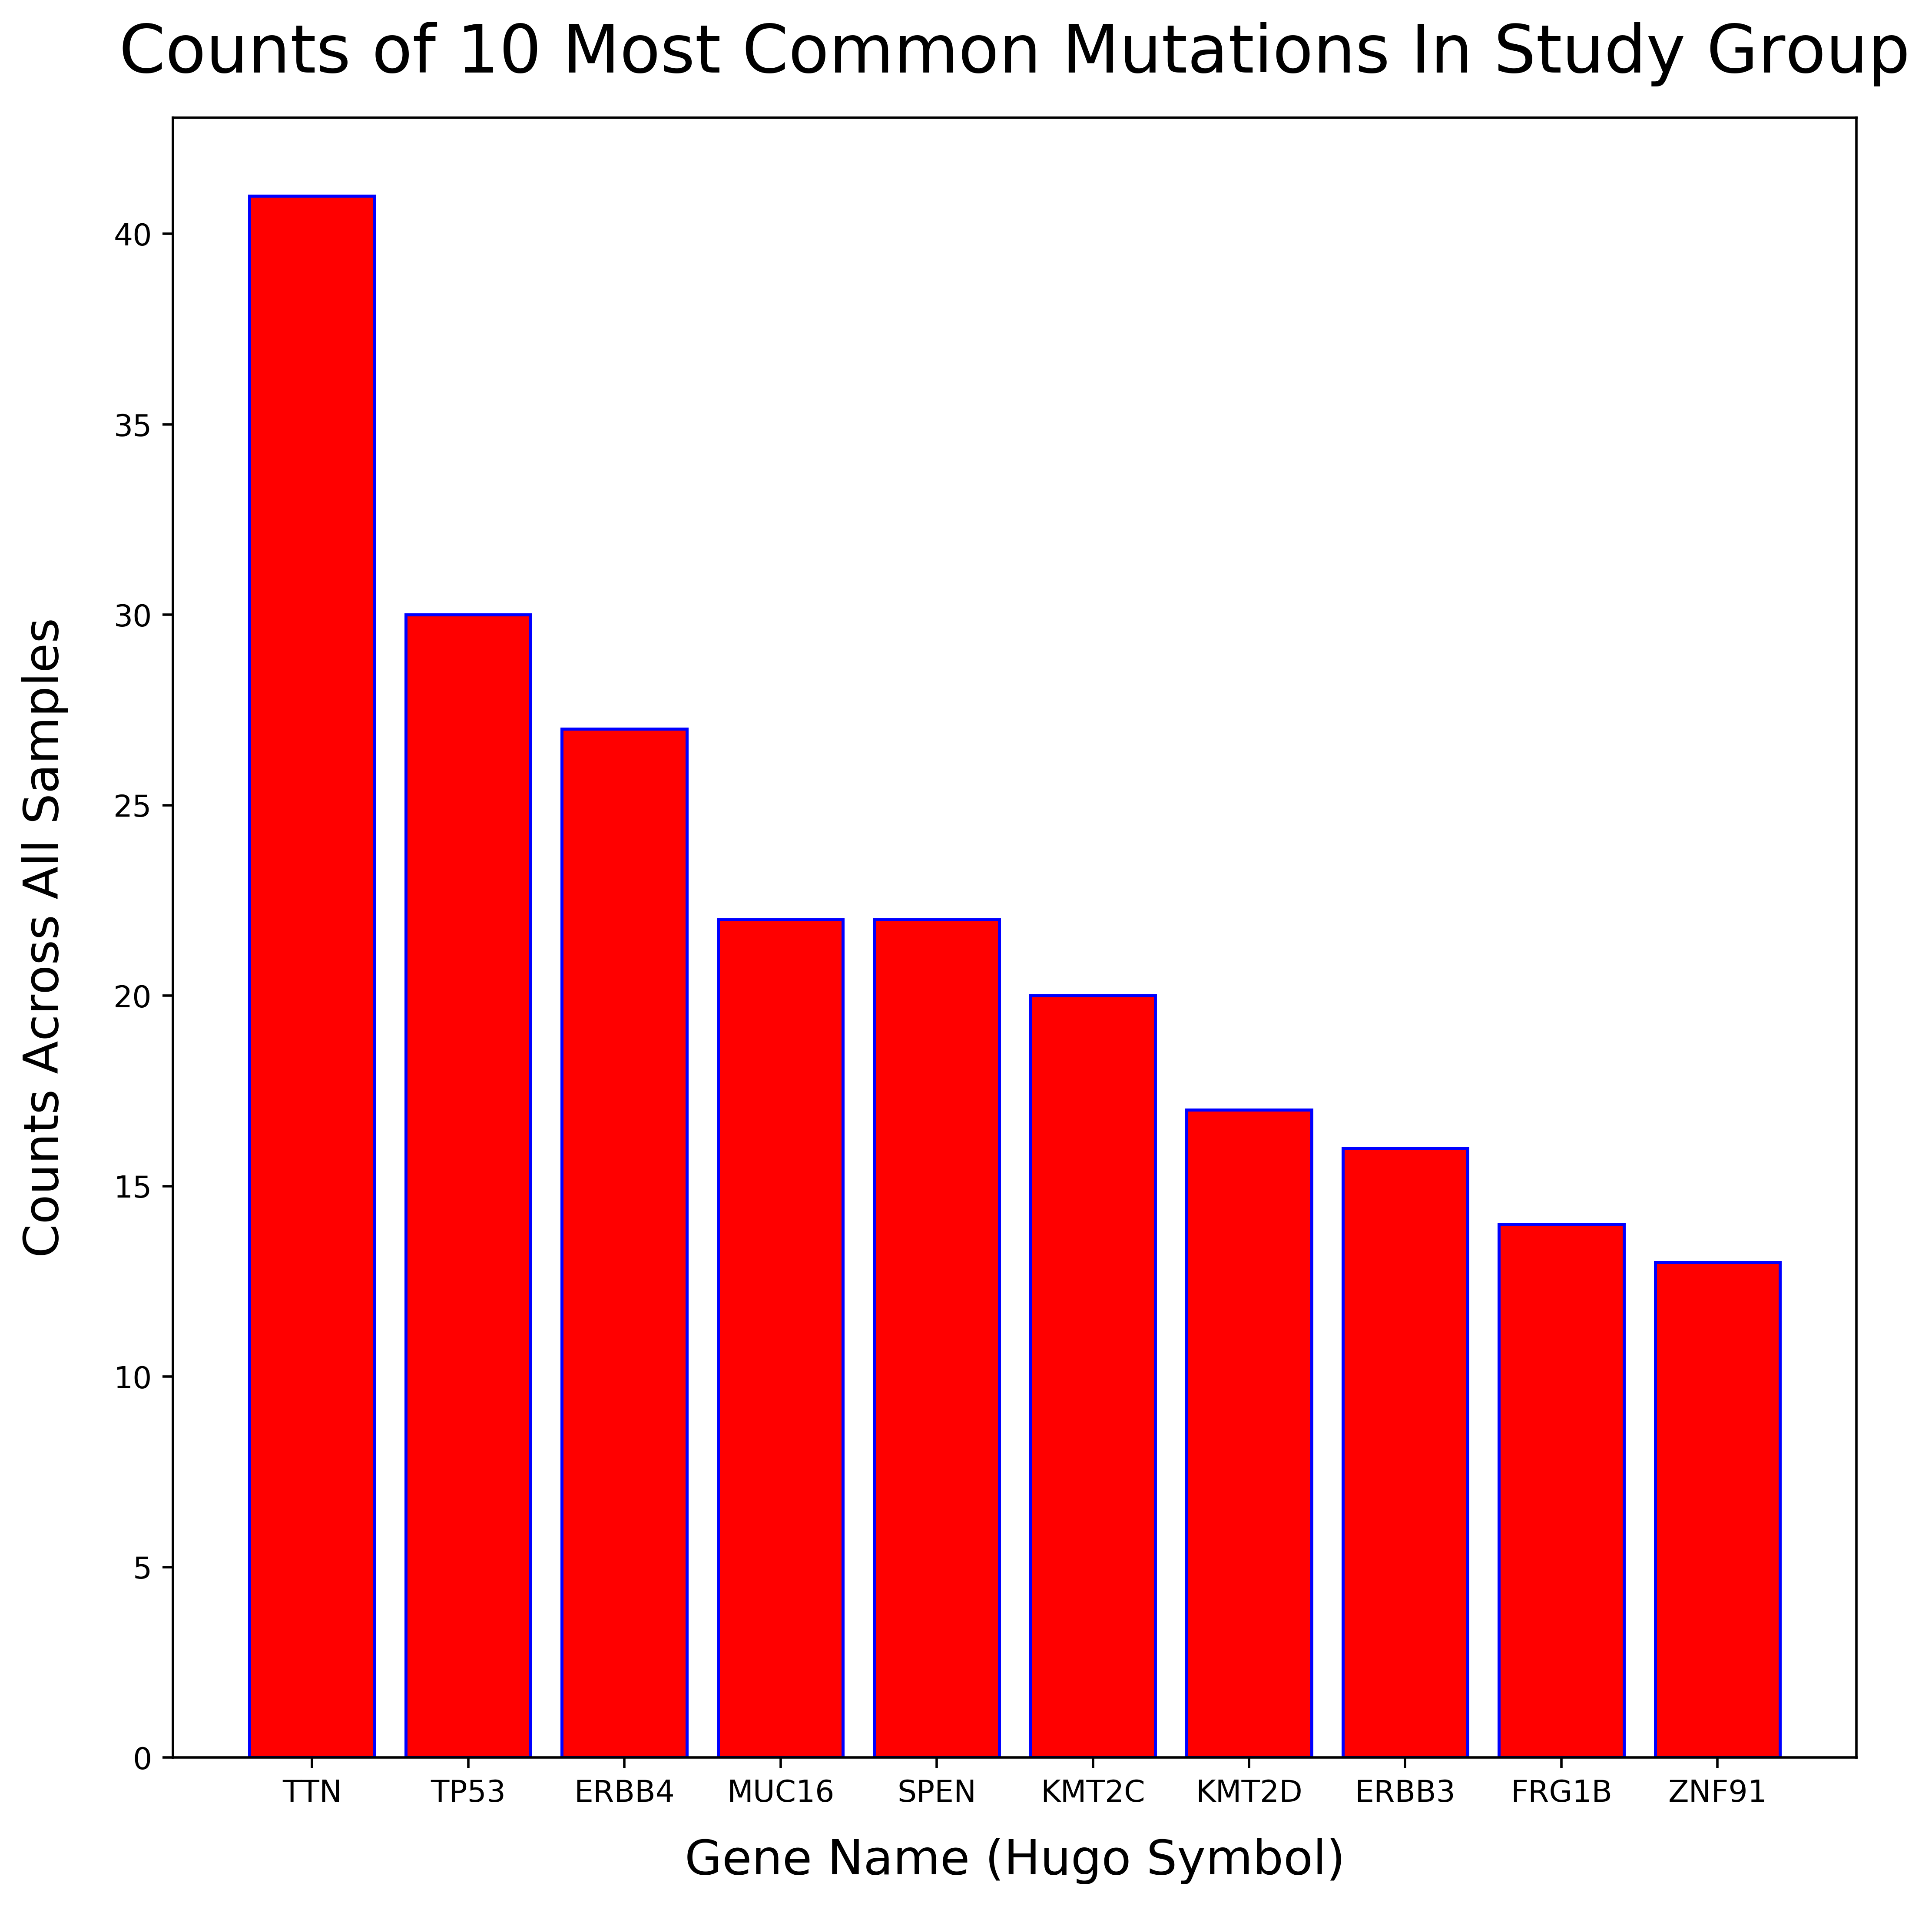

In [24]:
# adjust figure size and quality 
plt.figure(figsize=(10,10), dpi = 500)

# make bar plot 
plt.bar(histogram_plot_dict.keys(), histogram_plot_dict.values(), color="red", edgecolor="blue")

# update y label 
plt.ylabel("Counts Across All Samples", labelpad=15, size=16)
# update x label 
plt.xlabel("Gene Name (Hugo Symbol)", labelpad=10, size=16)
# update title 
plt.title("Counts of 10 Most Common Mutations In Study Group", size=22, pad=15)

#show plot
plt.show()

<h3>Are Any Mutated Genes Significantly Enriched in Patients who Responded or Not?</h3>